In [1]:
import pandas as pd
import os
import json
import numpy as np
import torch
from steams.data.KVyQVx import KVyQVx
from steams.models.mads import mads
from steams.tepe.steams import attention_steams
from steams.tepe.tepe import train, evaluation,prediction_prime,ensemble_prime
from steams.utils.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
else:
    num_workers = 0
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y",'rmse','variance'],
          "VALUE": ["value"],
          "nb_location" : 6000, # 6x1000, 6 sources
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y",'rmse_ref','variance_ref'],
          "VALUE": ["ref"],
          "nb_location" : 6000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train_6s")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid_6s")

valid_dataset = KVyQVx(params)

## model, optimizer, criterion, scheduler

In [9]:
#model
model = mads(device,type="krig",kernel="exp",input_k=4)

In [10]:
# optimzer
optimizer = torch.optim.Adam([model.W], lr=1e-4) #8e-3

# criterion
criterion = torch.nn.MSELoss()

# steams object
obj = attention_steams(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [11]:
# training
train(obj,train_dataset,valid_dataset,niter=10,n_iter_stop=20,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  0.528594  0.294033
  epoch     train     valid
0     1  0.245746  0.201828
  epoch     train   valid
0     2  0.224805  0.1992
  epoch     train     valid
0     3  0.223114  0.198038
  epoch     train     valid
0     4  0.219671  0.196641
  epoch     train     valid
0     5  0.222507  0.194256
  epoch     train     valid
0     6  0.219104  0.195842
  epoch     train     valid
0     7  0.219168  0.195322
  epoch     train     valid
0     8  0.219276  0.195962
  epoch     train     valid
0     9  0.220756  0.194063


In [12]:
obj.save_model(resdir,"3a-krig")

## Evaluation

In [13]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval_6s")

eval_dataset = KVyQVx(params)

In [14]:
criterion = R2()
obj.init_criterion(criterion)

In [15]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.6447914497057596


In [16]:
criterion = RMSE()
obj.init_criterion(criterion)

In [17]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.23050773819535972


In [18]:
criterion = variance()
obj.init_criterion(criterion)

In [19]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.03156415798359861


## QQplot

In [20]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval_6s")

eval_dataset = KVyQVx(params)

In [21]:
results = prediction_prime(obj,eval_dataset)

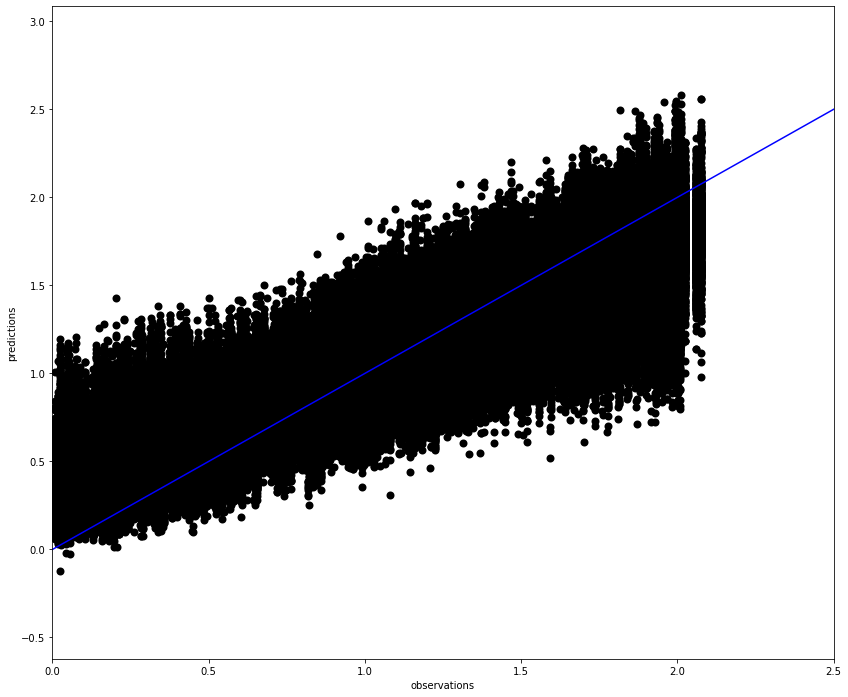

In [22]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','3a-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Wq

In [23]:
W = obj.model.W.detach()
W

tensor([9.2136e-01, 9.1399e-01, 6.4413e-39, 9.7998e-02])

## ensemble, quantiles and p-value 

In [24]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400_6s")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [25]:
# !! might take some time
ensemble = ensemble_prime(obj,eval_dataset,N=2)

In [26]:
ensemble.to_csv(os.path.join(resdir,'3a-ensemble.csv'))

### metrics

In [27]:
obs = torch.tensor(ensemble[('ref', 'mean')].to_numpy())
obs = torch.reshape(obs,(1,obs.shape[0],1))
q0_5 = torch.tensor(ensemble[('pred_ref','q0_5')].to_numpy())
q0_5 = torch.reshape(q0_5,(1,q0_5.shape[0],1))

In [28]:
criterion = R2()
criterion(obs,q0_5)

tensor(0.7693)

In [29]:
criterion = RMSE()
criterion(obs,q0_5)

tensor(0.1726)

In [30]:
criterion = variance()
criterion(obs,q0_5)

tensor(0.0199)

### qqplot of the observation against the median of the ensemble at each location

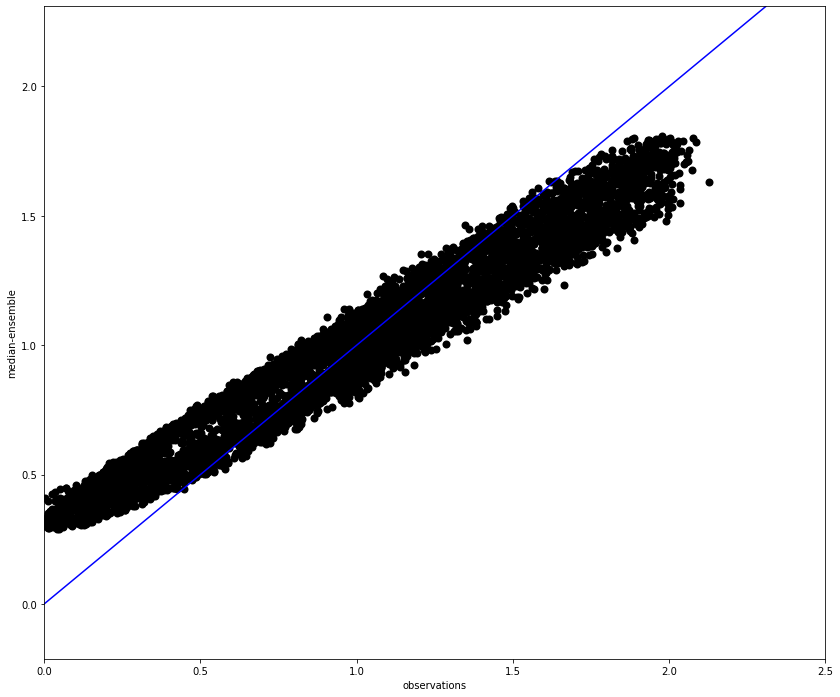

In [31]:
fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(ensemble[('ref', 'mean')],ensemble[('pred_ref','q0_5')], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(ensemble[('pred_ref','q0_5')].min().item()-0.5, ensemble[('pred_ref','q0_5')].max().item()+0.5)
ax.set(xlabel='observations', ylabel='median-ensemble')

fig_filename = os.path.join(parent_dir,'fig','3a-ensemble_q0_5_qqplot.png')
plt.savefig(fig_filename, dpi = 300)

### p-qqplot of the p-value of the obsevration within its ensemble against an uniform distribution

In [32]:
ensemble = ensemble.sort_values(by='p_ref')
ensemble["U"] = np.linspace(0, 1, num=ensemble.shape[0])    

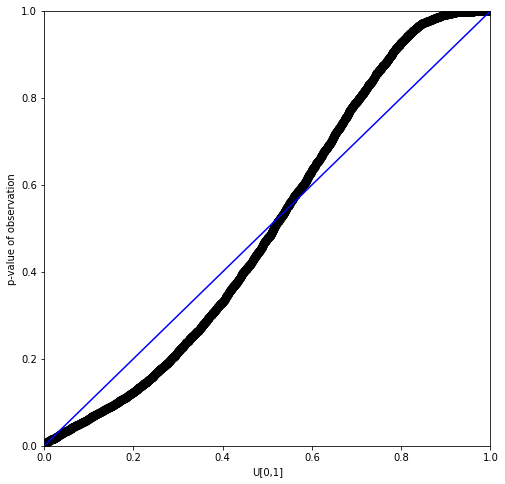

In [33]:
fig, ax= plt.subplots(figsize=(8, 8))
ax.scatter(ensemble['U'],ensemble['p_ref'], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
ax.set(xlabel='U[0,1]', ylabel='p-value of observation')

fig_filename = os.path.join(parent_dir,'fig','3a-p_qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of quantile on maps

In [34]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400_6s")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [35]:
# !! might take some time
ensemble = ensemble_prime(obj,eval_dataset,N=2)

In [36]:
vmax = np.array(
    np.abs(np.array([ensemble[('pred_ref','q0_05')] - ensemble[('pred_ref','q0_5')]])).max(),
    np.array([ensemble[('pred_ref','q0_95')] - ensemble[('pred_ref','q0_5')]]).max()).max()


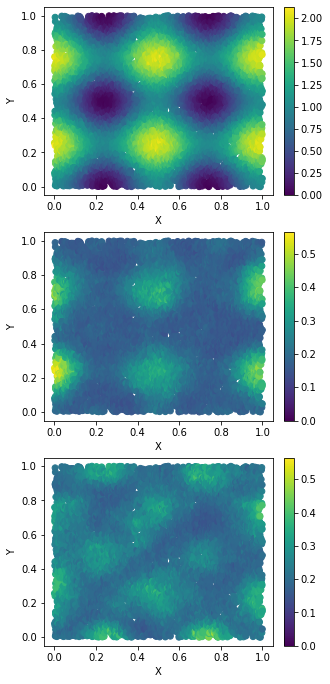

In [37]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=ensemble["x"], y=ensemble["y"], c=ensemble[('ref', 'mean')])
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[1,0])
c1 = ax1.scatter(x=ensemble["x"], y=ensemble["y"], c=np.abs(ensemble[('pred_ref', 'q0_05')]- ensemble[('pred_ref', 'q0_5')]), vmin = 0, vmax=vmax)
ax1.set(ylabel='Y',xlabel='X')

ax2 = fig.add_subplot(gs[2,0])
c2 = ax2.scatter(x=ensemble["x"], y=ensemble["y"], c=ensemble[('pred_ref', 'q0_95')] - ensemble[('pred_ref', 'q0_5')], vmin = 0, vmax=vmax)
ax2.set(ylabel='Y',xlabel='X')


fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)

fig_filename = os.path.join(parent_dir,'fig','2d-illustration_diff_median-q005_and_median-q095.png')
plt.savefig(fig_filename, dpi = 300)
